# Computer Vision (CV) Challenge:
I used a pre-trained ResNet 50 and train on the Flowers dataset.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

 This is the image transformations commonly used for image classification tasks with deep learning models.
- It ensures the data is in the correct format and normalized for model compatibility and training efficiency

In [3]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

data_transforms =transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

# data_transforms = {
#     'train':
#     transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         normalize
#     ]),
#     'validation':
#     transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.ToTensor(),
#         normalize
#     ]),
# }

image_datasets =datasets.ImageFolder('102flowers', data_transforms)




In [4]:
image_datasets

Dataset ImageFolder
    Number of datapoints: 8189
    Root location: 102flowers
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# below codes enable efficient loading and iterating over datasets 

In [5]:

dataloaders = {
    torch.utils.data.DataLoader(image_datasets,
                                batch_size=32,
                                shuffle=True, num_workers=4),
}

In [6]:
dataloaders

{<torch.utils.data.dataloader.DataLoader at 0x205e60776d0>}

# At this stage, we load the file in which we find the constraint of training,validation and testing dataset

In [7]:
from torch.utils.data import Subset, DataLoader

In [8]:
import scipy.io as sio
mat_data = sio.loadmat('flower_dataset/setid.mat')
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [9]:
validation_ids=mat_data['valid'][0]-1
training_ids=mat_data['trnid'][0]-1
testing_ids=mat_data['trnid'][0]-1

In [10]:
train_dataset = Subset(image_datasets, training_ids)
val_dataset = Subset(image_datasets,validation_ids)
testing_dataset=Subset(image_datasets, testing_ids)
datasets_dict = {
    "train": train_dataset,
    "validation": val_dataset,
    "testing": testing_dataset
}

In [11]:
# for inputs, labels in dataloaders:
#     # Your code here
#     print(inputs)
 

In [12]:
print(next(iter(dataloaders)))

In [13]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(train_dataset,
                                batch_size=32,
                                shuffle=True, num_workers=4),
    'validation':
    torch.utils.data.DataLoader(val_dataset,
                                batch_size=32,
                                shuffle=False, num_workers=4),
    'testing':
    torch.utils.data.DataLoader(testing_dataset,
                               batch_size=32,
                               shuffle=False, num_workers=4)
}

In [14]:
# for inputs, labels in dataloaders["train"]:
#     # Your code here
#     print(inputs)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [19]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation','testing']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_dict[phase])
            epoch_acc = running_corrects.float() / len(datasets_dict[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [20]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.0209, acc: 0.9951
validation loss: 0.0000, acc: 1.0000
testing loss: 0.0000, acc: 1.0000
Epoch 2/3
----------
train loss: 0.0000, acc: 1.0000
validation loss: 0.0000, acc: 1.0000
testing loss: 0.0000, acc: 1.0000
Epoch 3/3
----------
train loss: 0.0000, acc: 1.0000
validation loss: 0.0000, acc: 1.0000
testing loss: 0.0000, acc: 1.0000


# Result's Explanation 
The model learned quickly and achieved perfect accuracy on both the validation and testing sets within the first epoch.

This suggests that the model is well-suited to the task and the dataset, and that the training process was effective.
# *The training loss reached 0.0000, which might indicate overfitting.*

Despite the potential for overfitting, the model maintained perfect accuracy on both the validation and testing sets throughout all three epochs.


# To address overfitting

# 1. DropOut

In [22]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add dropout layer
    nn.Linear(128, 2)
).to(device)

In [23]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.8274, acc: 0.1343
validation loss: 0.8256, acc: 0.0147
testing loss: 0.8268, acc: 0.0157
Epoch 2/3
----------
train loss: 0.8362, acc: 0.1314
validation loss: 0.8263, acc: 0.0176
testing loss: 0.8269, acc: 0.0118
Epoch 3/3
----------
train loss: 0.8312, acc: 0.1461
validation loss: 0.8241, acc: 0.0127
testing loss: 0.8239, acc: 0.0127


**Epoch 1:** Training loss increased, and accuracy decreased .

**Epoch 2:** The trend continued with a slight decrease in accuracy and an increase in loss .

**Epoch 3:** The training loss remained relatively stable , and accuracy decreased .

**Validation and Testing Accuracy:** Validation accuracy slightly decreased over epochs, while testing accuracy showed fluctuation but remained within a similar range.

# *Introducing dropout has likely regularized the model, preventing overfitting to the training data. However, it seems to have impacted training accuracy negatively.*

# 2. Regularization

In [24]:
weight_decay = 1e-4  # Adjust the regularization strength
optimizer = optim.Adam(model.fc.parameters(), weight_decay=weight_decay)

In [25]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.0275, acc: 0.9706
validation loss: 0.0000, acc: 1.0000
testing loss: 0.0000, acc: 1.0000
Epoch 2/3
----------
train loss: 0.0000, acc: 1.0000
validation loss: 0.0000, acc: 1.0000
testing loss: 0.0000, acc: 1.0000
Epoch 3/3
----------
train loss: 0.0000, acc: 1.0000
validation loss: 0.0000, acc: 1.0000
testing loss: 0.0000, acc: 1.0000


***It seems that introducing regularization has significantly improved our model's performance.***

**Epoch 1:** Training loss decreased to 0.0275, and accuracy increased to 97.06%.

**Epoch 2 and 3:** Training loss remained at 0.0000, and accuracy stayed at 100.00%. This suggests that the model is fitting the training data well.

# Validation and Testing Performance:

Both validation and testing losses are at 0.0000, indicating that the model is performing exceptionally well on unseen data.

Validation and testing accuracies are at 100.00%, suggesting that the model is generalizing effectively.

# Saving a model in specified directory

In [32]:
torch.save(model_trained.state_dict(), 'models/weights.h5')

In [35]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add dropout layer
    nn.Linear(128, 2)
).to(device)
model.load_state_dict(torch.load('models/weights.h5'))

<All keys matched successfully>

In [36]:
import pandas as pd
import tarfile
import PIL
import scipy

In [37]:
dataset_path='flower_dataset/'

# a function to open and get filenames under the tar file

In [38]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

# Opening the file in the dataframe

In [39]:
df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(dataset_path+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(dataset_path+'imagelabels.mat')['labels'][0] - 1  
df['Segmentation']=sorted(get_all_filenames(dataset_path+"102segmentations.tgz"))
df['Category'] = df['Category'].astype(str)

In [40]:
validation_set=df.iloc[mat_data['valid'][0]-1]

# Plotting the flowers 

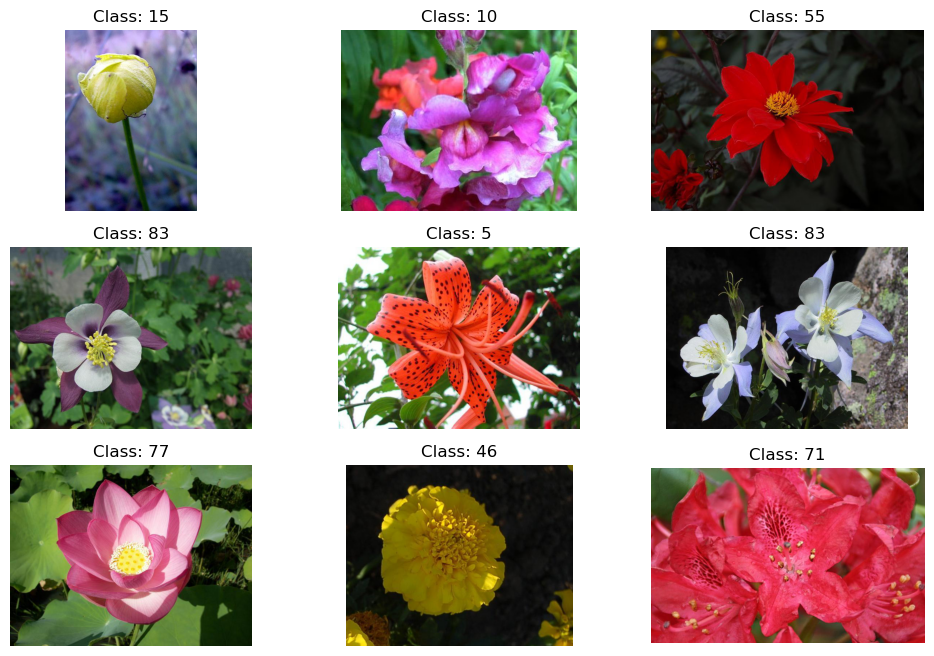

In [41]:
images_path='102flowers/'
plt.figure(figsize=(12,8))

random_image = validation_set.sample(n=9)

random_image_paths= random_image['Id'].values
random_image_cat=random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im=PIL.Image.open(images_path+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: ' +str(random_image_cat[index]))
    plt.axis('off')
plt.show()


In [42]:
image_list_path=[]
for index, path in enumerate(random_image_paths):
    image_list_path.append(images_path+path)

In [43]:
image_list_path

['102flowers/jpg/image_06678.jpg',
 '102flowers/jpg/image_03156.jpg',
 '102flowers/jpg/image_02854.jpg',
 '102flowers/jpg/image_02581.jpg',
 '102flowers/jpg/image_08111.jpg',
 '102flowers/jpg/image_02566.jpg',
 '102flowers/jpg/image_01886.jpg',
 '102flowers/jpg/image_05019.jpg',
 '102flowers/jpg/image_03566.jpg']

In [44]:
img_list = [Image.open(img_path) for img_path in image_list_path]
img_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x687>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=649x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=752x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x501>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=782x500>]

In [51]:
# pred_logits_tensor = model(validation_batch)
# pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

In [40]:
# pred_probs

In [41]:
# probs, classes = pred_probs[0]

In [42]:
# fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
# for i, img in enumerate(img_list):
#     ax = axs[i]
#     ax.axis('off')
#     plt.title('Class: ' +str(random_image_cat[index]))
# #     ax.set_title("{:.0f}%, {:.0f}% Predator".format(100*pred_probs[i,0],
# #                                                           100*pred_probs[i,1]))
#     ax.imshow(img)

In [52]:
# Load image using PIL
image = img_list[0]

# Apply transformations and convert to a batch of size 1
image_tensor = data_transforms(image).unsqueeze(0)

In [53]:
# Move model to GPU (if available)
model = model.to('cuda')

# ... (rest of your prediction code)

with torch.no_grad():
    outputs = model(image_tensor.to('cuda'))  # Move input to GPU as well

In [54]:
# Assuming model is on GPU and input is correctly prepared
outputs = model(image_tensor.to('cuda'))

_, predicted_class = torch.max(outputs.data, 1)
predicted_class = predicted_class.item()

print("Predicted Category Index:", predicted_class)
categories=df['Category'].unique()
predicted_category = categories[predicted_class]  # Replace "categories" with your actual list name
print("Predicted Category Name: Class", predicted_category)

Predicted Category Index: 0
Predicted Category Name: Class 76


In [55]:
df['Category'].unique()

array(['76', '72', '87', '88', '80', '45', '73', '50', '43', '81', '82',
       '77', '79', '74', '40', '42', '75', '83', '57', '55', '85', '59',
       '91', '10', '64', '7', '22', '29', '71', '52', '36', '16', '11',
       '28', '51', '17', '35', '89', '70', '39', '47', '54', '84', '90',
       '19', '46', '58', '1', '4', '27', '69', '21', '53', '86', '65',
       '31', '3', '41', '12', '37', '62', '67', '68', '92', '13', '63',
       '18', '48', '60', '49', '14', '8', '32', '25', '24', '2', '15',
       '78', '0', '20', '23', '26', '30', '33', '34', '38', '66', '9',
       '44', '5', '6', '56', '61', '93', '94', '95', '96', '97', '98',
       '99', '100', '101'], dtype=object)

In [56]:
testing_dataset